In [1]:
#Installing XGBoost
!pip install xgboost

  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.26.5-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
Using cached nvidia_nccl_cu12-2.26.5-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (318.1 MB)


In [2]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import xgboost as xg
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  precision_score, recall_score, f1_score
from xgboost import XGBRegressor
from sklearn.utils.class_weight import compute_sample_weight
from openpyxl import load_workbook

In [3]:
#Reading the excel-document into a df
df = pd.read_excel('dataset_name.xlsx', Sheet_name = 'Sheet_name') 

#Choosing which columns to keep and saving them in a new df
columns_to_keep = ['Column 1', 'Column 2', 'Column 3', 'Column 4', 'Column 5', '...']
df2 = df[columns_to_keep].copy()

,Class_stat,Hole_id_stat,TAPPI_stat,mean_PenetrRate,mean_PercPressure,mean_FeedPressure,mean_DampPressure,mean_RotPressure,mean_FlushPressure,std_PenetrRate,std_PercPressure,std_FeedPressure,std_DampPressure,std_RotPressure,std_FlushPressure
0,5,204,93.05,1.787786,186.244429,60.927071,68.153714,54.656571,5.817286,0.177458,7.176681,3.726609,6.888868,4.524692,0.041707
1,4,204,93.58,1.868158,181.128368,62.353947,72.092789,52.927053,5.725474,0.133978,7.036334,2.351530,3.987699,2.503516,0.037038
2,3,204,94.11,1.828625,183.040938,63.598750,72.581250,53.676125,5.945938,0.163291,10.210424,2.048423,2.117603,2.622698,0.092238
3,5,204,92.25,1.835500,187.394786,68.982714,79.429929,59.953714,6.041214,0.108228,13.915185,6.306191,8.780566,2.254650,0.043496
4,6,204,91.09,1.797812,187.362687,63.907688,70.234937,58.601500,6.505375,0.149958,6.786575,4.054791,6.579858,2.439304,0.133709
5,5,204,92.12,1.821444,186.731667,61.410778,68.436389,58.458833,6.747333,0.159652,2.758141,3.398073,5.943611,1.945159,0.037514
6,2,205,95.21,1.557313,192.589125,63.567438,68.599875,53.859750,5.079687,0.298300,3.686132,2.328023,4.300900,3.360966,0.057866
7,3,205,94.10,1.591889,192.306611,64.909278,73.251556,50.812222,5.012389,0.135514,3.223561,0.573715,1.513904,2.428976,0.024522
8,4,205,93.65,1.585765,191.292118,64.853471,69.568471,52.723882,5.534059,0.122986,9.328581,1.074497,1.987244,2.084592,0.033107
9,4,205,93.61,1.657059,192.600294,64.905235,71.375000,52.196647,5.532412,0.113353,0.641645,0.526885,1.498626,1.346753,0.016758


In [4]:
#Splitting df into two based on hole ID
df2.loc[:, 'Hole_id_stat_str'] = df2['Hole_id_stat'].astype(str)
columns_unseen = ['209']
df_train = df2[~df2['Hole_id_stat_str'].isin(columns_unseen)] 
df_unseen = df2[df2['Hole_id_stat_str'].isin(columns_unseen)] 


In [5]:
#Defining which columns to keep av model input
X = df_train.drop(columns = ['Column 1', 'Column 2', 'Column 3'])

#Defining which columns are the model outputs
y = df_train['Column 4']

#Defining inputs and outputs for unseen dataset
X_unseen = df_unseen.drop(columns = ['Column 1', 'Column 2', 'Column 3')
y_unseen = df_unseen['Column 4'] 

Class_stat
4    4
3    4
2    4
1    4
5    3
6    3
Name: count, dtype: int64


In [6]:
#Encode labels before splitting, ensures all class labels are integers
le = LabelEncoder()
y_fixed = le.fit_transform(y) 
print("Encoded Classes:", le.classes_)

#Using K-Fold cross-validation to split the data into 5 folds
k_fold = KFold(n_splits= 5, shuffle=True, random_state=66)

#Creating lists to store splits
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

#Performing KFold splitting 
for fold_num, (train_idx, test_idx) in enumerate(k_fold.split(X, y_fixed)):
    print(f"\nProcessing Fold {fold_num + 1}")

    #Getting splits
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y_fixed[train_idx], y_fixed[test_idx]

    print(f"Unique labels in y_train: {np.unique(y_train)}")
    print(f"Unique labels in y_test: {np.unique(y_test)}")

    #Storing splits
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

#Using the first fold for training/testing
X_train, X_test = X_train_list[0], X_test_list[0]
y_train, y_test = y_train_list[0], y_test_list[0]

#Printing results check
print(f"\nFINAL CHECK:")
print(f"Unique labels in FINAL y_train: {np.unique(y_train)}")
print(f"Unique labels in FINAL y_test: {np.unique(y_test)}")


 Encoded Classes: [1 2 3 4 5 6]
 Class Counts BEFORE splitting: [4 4 4 4 3 3]
 Rare classes (kept only in training): []
 Using n_splits=3
 Expected classes: [0 1 2 3 4 5]

 Processing Fold 1
 Classes in y_train BEFORE fix: [0 1 2 3 4 5]
 Classes in y_test BEFORE fix: [0 1 2 3 4 5]
 Final unique labels in y_train (Fold 1): [0 1 2 3 4 5]
 Final unique labels in y_test (Fold 1): [0 1 2 3 4 5]

 Processing Fold 2
 Classes in y_train BEFORE fix: [0 1 2 3 4 5]
 Classes in y_test BEFORE fix: [0 1 2 3 4 5]
 Final unique labels in y_train (Fold 2): [0 1 2 3 4 5]
 Final unique labels in y_test (Fold 2): [0 1 2 3 4 5]

 Processing Fold 3
 Classes in y_train BEFORE fix: [0 1 2 3 4 5]
 Classes in y_test BEFORE fix: [0 1 2 3 4 5]
 Final unique labels in y_train (Fold 3): [0 1 2 3 4 5]
 Final unique labels in y_test (Fold 3): [0 1 2 3 4 5]

 FINAL CHECK:
 Unique labels in FINAL y_train: [0 1 2 3 4 5]
 Unique labels in FINAL y_test: [0 1 2 3 4 5]


In [7]:
#Standardizing input features using StandardScaler
scaler = StandardScaler() 

#Fitting the scaler on the training data and transforming it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

#Using the same scaler to transform the test data 
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

Unique Train Labels: [0 1 2 3 4 5]
Unique Test Labels: [0 1 2 3 4 5]
X_train_scaled shape: (14, 13)
y_train shape: (14,)


In [8]:
#Defining the XGBoost classifier 
XGB = XGBClassifier(
    objective="multi:softprob",              
    eval_metric="mlogloss",                 
    num_class=len(np.unique(y_train)),      
    use_label_encoder=False,                 
    random_state=42)

In [130]:
#Defining the hyperparameter grid 
param_grid = {
    'n_estimators': [75],         
    'max_depth': [5,10,15],              
    'learning_rate': [0.2,0.5,0.7],        
    'subsample': [0.4, 0.6],        
    'colsample_bytree': [0.2, 0.4], 
    'reg_alpha': [0, 1, 5],         
    'reg_lambda': [0, 1, 5]}

#Setting up GridSearchCV to find the best combination of hyperparameters
CV_XGB = GridSearchCV(
    estimator=XGB,                 
    param_grid=param_grid,        
    cv=3,                          
    scoring='accuracy',           
    n_jobs=-1,                     
    verbose=1)

#Computing sample weights to balance class imbalance during training
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

#Fitting GridSearchCV to the training data with sample weights
CV_XGB.fit(X_train_scaled, y_train, sample_weight=sample_weights)

#Printing the best hyperparameter combination found
print('Best Parameters: ', CV_XGB.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters:  {'colsample_bytree': 0.2, 'learning_rate': 0.7, 'max_depth': 15, 'n_estimators': 75, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.4}


In [131]:
#Retrieving the best XGBoost model found by GridSearchCV
XGB_best = CV_XGB.best_estimator_

#Making predictions on the training data using the best model
pred_train = XGB_best.predict(X_train_scaled)

#Making predictions on the test data using the best model
pred_test = XGB_best.predict(X_test_scaled)

Accuracy: 0.9286
Precision: 0.9524
Recall: 0.9286
F1 Score: 0.9286


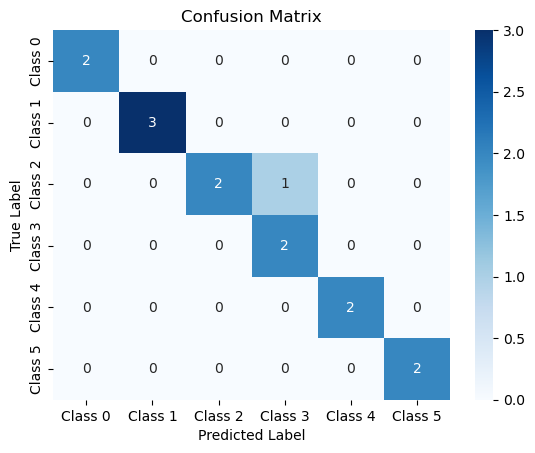

In [132]:
#Calculating performance metrics
acc_train = accuracy_score(y_train, pred_train)
precision_train = precision_score(y_train, pred_train, average='weighted', zero_division=1)
recall_train = recall_score(y_train, pred_train, average='weighted')
f1_train = f1_score(y_train, pred_train, average='weighted')

#Printing all evaluation metrics with 4 decimals
print(f'Accuracy: {acc_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall: {recall_train:.4f}')
print(f'F1 Score: {f1_train:.4f}')

#Computing the confusion matrix 
cm = confusion_matrix(y_train, pred_train)

#Creating readable labels for the axes
class_labels = [f"Class {i}" for i in np.unique(y_train)]

#Visualizing the confusion matrix 
sns.heatmap(
    cm,
    annot=True,             
    fmt="d",                
    cmap="Blues",           
    xticklabels=class_labels, 
    yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.7500
Precision: 0.8889
Recall: 0.7500
F1 Score: 0.7292


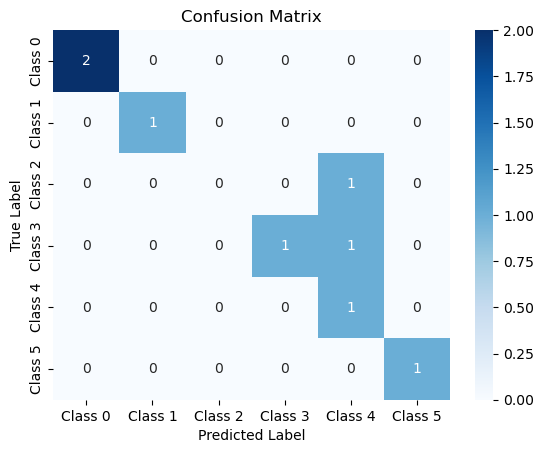

In [133]:
#Calculating performance metrics for test data
acc_test = accuracy_score(y_test, pred_test)
precision_test = precision_score(y_test, pred_test, average="macro", zero_division=1)
recall_test = recall_score(y_test, pred_test, average="macro", zero_division=1)
f1_test = f1_score(y_test, pred_test, average='weighted')

#Printing the evaluation metrics with 4 decimals
print(f'Accuracy: {acc_test:.4f}')
print(f'Precision: {precision_test:.4f}')
print(f'Recall: {recall_test:.4f}')
print(f'F1 Score: {f1_test:.4f}')

#Creating a confusion matrix 
cm = confusion_matrix(y_test, pred_test)

#Creating labels based on y_test
class_labels = [f"Class {i}" for i in np.unique(y_test)]

#Plotting the confusion matrix
sns.heatmap(
    cm,
    annot=True,             
    fmt="d",                
    cmap="Blues",           
    xticklabels=class_labels,
    yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy: 0.7143
Precision: 1.0000
Recall: 0.7143
F1 Score: 0.8095


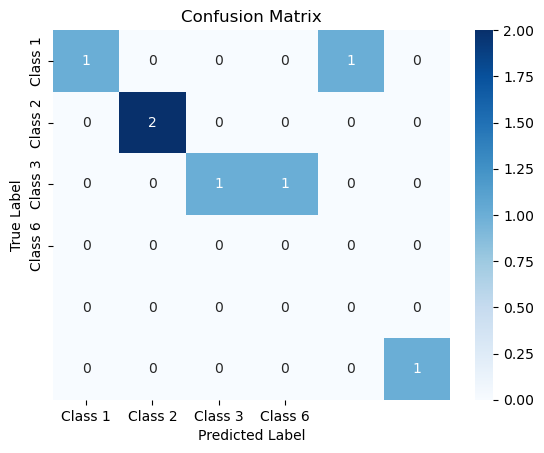

In [134]:
#Sacling the unseen inputs with the scaler fitted on the training data
X_unseen_scaled = scaler.transform(X_unseen)
y_pred_unseen = XGB_best.predict(X_unseen_scaled)
y_unseen_encoded = le.transform(y_unseen)

#calculating performance metrics on the unseen data
acc_unseen = accuracy_score(y_unseen_encoded, y_pred_unseen)  
precision_unseen = precision_score(y_unseen_encoded, y_pred_unseen, average='weighted', zero_division=0)  
recall_unseen = recall_score(y_unseen_encoded, y_pred_unseen, average='weighted', zero_division=0)        
f1_unseen = f1_score(y_unseen_encoded, y_pred_unseen, average='weighted', zero_division=0)                 

#Printing the evaluation metrics
print(f'Accuracy: {acc_unseen:.4f}')
print(f'Precision: {precision_unseen:.4f}')
print(f'Recall: {recall_unseen:.4f}')
print(f'F1 Score: {f1_unseen:.4f}')


#Generating the confusion matrix 
cm_unseen = confusion_matrix(y_unseen_encoded, y_pred_unseen)

#Creating labels based on y_unseen
class_labels = [f"Class {i}" for i in np.unique(y_unseen)]

#Visualizing the confusion matrix 
sns.heatmap(
    cm_unseen,
    annot=True,                
    fmt="d",                  
    cmap="Blues",            
    xticklabels=class_labels,  
    yticklabels=class_labels   )

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [135]:
#Defining a function to log model evaluation metrics and hyperparameters to an Excel-file of chosen name
def log_results(model_name, params, accuracy_train, precision_train, recall_train, f1_train,
                accuracy_test, precision_test, recall_test, f1_test,
                accuracy_unseen, precision_unseen, recall_unseen, f1_unseen,
                filename="Results.xlsx"):
    """ Logs classification model results in separate sheets within the same Excel file, ensuring appending works correctly. """

    #Creating DataFrame for this model run
    result = pd.DataFrame([{
        **params, 
        "Accuracy_Train": accuracy_train,
        "Precision_Train": precision_train,
        "Recall_Train": recall_train,
        "F1_Train": f1_train,
        "Accuracy_Test": accuracy_test,
        "Precision_Test": precision_test,
        "Recall_Test": recall_test,
        "F1_Test": f1_test,
        "Accuracy_Unseen": accuracy_unseen,
        "Precision_Unseen": precision_unseen,
        "Recall_Unseen": recall_unseen,
        "F1_Unseen": f1_unseen
    }])

    #Introducing a short delay to avoid file conflicts if running in multiple notebooks
    time.sleep(1)

    # Check if the file exists
    file_exists = os.path.exists(filename)

    if not file_exists:
        # If file doesn't exist, create a new one
        with pd.ExcelWriter(filename, engine="openpyxl", mode="w") as writer:
            result.to_excel(writer, sheet_name=model_name, index=False)
    else:
        # If file exists, load it properly before appending
        try:
            with pd.ExcelWriter(filename, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
                # Read existing sheet (if it exists)
                try:
                    existing_df = pd.read_excel(filename, sheet_name=model_name, engine="openpyxl")
                    df_combined = pd.concat([existing_df, result], ignore_index=True)
                except (FileNotFoundError, ValueError):
                    df_combined = result  # If sheet does not exist, create it

                # Save results, ensuring correct appending
                df_combined.to_excel(writer, sheet_name=model_name, index=False)

        except PermissionError:
            print(f"Error: Close the Excel file ({filename}) before running the script again.")

    print(f"Logged results for {model_name}: Train Accuracy={accuracy_train:.4f}, Test Accuracy={accuracy_test:.4f}, Unseen Accuracy={accuracy_unseen:.4f}")


In [136]:
log_results(
    model_name="XGBoost",
    params=best_params,

    accuracy_train=accuracy_score(y_train, pred_train),
    precision_train=precision_score(y_train, pred_train, average='weighted', zero_division=0),
    recall_train=recall_score(y_train, pred_train, average='weighted', zero_division=0),
    f1_train=f1_score(y_train, pred_train, average='weighted', zero_division=0),

    accuracy_test=accuracy_score(y_test, pred_test),
    precision_test=precision_score(y_test, pred_test, average='weighted', zero_division=0),
    recall_test=recall_score(y_test, pred_test, average='weighted', zero_division=0),
    f1_test=f1_score(y_test, pred_test, average='weighted', zero_division=0),

    accuracy_unseen=accuracy_score(y_unseen_encoded, y_pred_unseen),
    precision_unseen=precision_score(y_unseen_encoded, y_pred_unseen, average='weighted', zero_division=0),
    recall_unseen=recall_score(y_unseen_encoded, y_pred_unseen, average='weighted', zero_division=0),
    f1_unseen=f1_score(y_unseen_encoded, y_pred_unseen, average='weighted', zero_division=0)
)


Logged results for XGBoost: Train Accuracy=0.9286, Test Accuracy=0.7500, Unseen Accuracy=0.7143
